In [2]:
import argparse
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from captum.attr import GradientShap, IntegratedGradients, Saliency
from torch.utils.data import DataLoader, RandomSampler, Subset, random_split

from lfxai.explanations.examples import (
    TracIn,
)
from lfxai.explanations.features import attribute_auxiliary
from lfxai.models.time_series import RecurrentAutoencoder
from lfxai.utils.datasets import ECG5000
from lfxai.utils.feature_attribution import generate_tseries_masks
from lfxai.utils.metrics import similarity_rates

In [3]:
# Parameters model
random_seed: int = 1
batch_size: int = 50
dim_latent: int = 16
n_epochs: int = 150
checkpoint_interval: int = 10

torch.random.manual_seed(random_seed)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
data_dir = Path.cwd() / "data/ecg5000"
save_dir = Path.cwd() / "results/ecg5000/consistency_examples"
if not save_dir.exists():
    os.makedirs(save_dir)

In [6]:
# Load dataset
train_dataset = ECG5000(data_dir, experiment="examples")
train_dataset, test_dataset = random_split(train_dataset, (4000, 1000))
train_loader = DataLoader(train_dataset, batch_size, True)
test_loader = DataLoader(test_dataset, batch_size, False)
time_steps = 140
n_features = 1

/usr/local/lib/python3.10/dist-packages/lfxai/utils/datasets.py:284: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_df = total_df.append(pd.DataFrame(data))


In [7]:
torch.save(train_dataset, 'data/ecg5000/train_dataset.pt')
torch.save(test_dataset, 'data/ecg5000/test_dataset.pt')

In [8]:
train_dataset = torch.load('data/ecg5000/train_dataset.pt')
test_dataset = torch.load('data/ecg5000/test_dataset.pt')
train_loader = DataLoader(train_dataset, batch_size, True)
test_loader = DataLoader(test_dataset, batch_size, False)
time_steps = 140
n_features = 1

In [9]:
# Train the denoising autoencoder
autoencoder = RecurrentAutoencoder(time_steps, n_features, dim_latent)
save_dir = Path.cwd() / "results/ecg5000/consistency_examples"
if not save_dir.exists():
    os.makedirs(save_dir)
autoencoder.fit(
    device,
    train_loader,
    test_loader,
    save_dir,
    n_epochs,
    checkpoint_interval=checkpoint_interval,
)

In [10]:
autoencoder.load_state_dict(
    torch.load(save_dir / (autoencoder.name + ".pt")), strict=False
)

<All keys matched successfully>

In [11]:
subtrain_sizes = [200, 500, 1000]
subtest_size: int = 200

In [12]:
# Prepare subset loaders for example-based explanation methods

idx_subtest = torch.randperm(len(test_dataset))[:subtest_size]
torch.save(idx_subtest, 'results/ecg5000/consistency_examples/results_idx_subtest.pt')

for subtrain_size in subtrain_sizes:
  y_train = torch.tensor([train_dataset[k][1] for k in range(len(train_dataset))])
  idx_subtrain = [
      torch.nonzero(y_train == (n % 2))[n // 2].item() for n in range(subtrain_size)
  ]
  torch.save(idx_subtrain, f'results/ecg5000/consistency_examples/results_idx_subtrain{subtrain_size}.pt')

In [13]:
autoencoder.train().to(device)
l1_loss = torch.nn.L1Loss()

idx_subtest = torch.load('results/ecg5000/consistency_examples/results_idx_subtest.pt')
test_subset = Subset(test_dataset, idx_subtest)
subtest_loader = DataLoader(test_subset)
labels_subtest = torch.cat([label for _, label in subtest_loader])

In [14]:
# Fitting explainer, computing the metrics and saving everything
results_dict = {}
for subtrain_size in subtrain_sizes:
  explainer = TracIn(autoencoder, l1_loss, save_dir / f"tracin_grads_{subtrain_size}")

  idx_subtrain = torch.load(f'results/ecg5000/consistency_examples/results_idx_subtrain{subtrain_size}.pt')
  train_subset = Subset(train_dataset, idx_subtrain)
  subtrain_loader = DataLoader(train_subset)
  #labels_subtrain = torch.cat([label for _, label in subtrain_loader])

  attribution = explainer.attribute_loader(
            device, subtrain_loader, subtest_loader
        )
  autoencoder.load_state_dict(
        torch.load(save_dir / (autoencoder.name + ".pt")), strict=False
    )
  autoencoder.train().to(device)
  results_dict[subtrain_size] = attribution


 90%|████████▉ | 179/200 [00:00<00:00, 212.05example/s]
                                                       
 90%|█████████ | 181/200 [00:00<00:00, 208.65example/s]
                                                       

  0%|          | 0/40000 [00:00<?, ?it/s]

 94%|█████████▍| 189/200 [00:00<00:00, 202.76example/s]
                                                       
100%|█████████▉| 199/200 [00:00<00:00, 209.94example/s]
                                                       

  0%|          | 0/40000 [00:00<?, ?it/s]

 99%|█████████▉| 198/200 [00:01<00:00, 157.86example/s]
                                                       
100%|██████████| 200/200 [00:01<00:00, 152.72example/s]
                                                       

  0%|          | 0/40000 [00:00<?, ?it/s]

 98%|█████████▊| 195/200 [00:01<00:00, 146.97example/s]
                                                       
 94%|█████████▎| 187/200 [00:01<00:00, 151.92example/s]
                                                       

  0%|          | 0/40000 [00:00<?, ?it/s]

 90%|█████████ | 181/200 [00:01<00:00, 142.41example/s]
                                                       
 96%|█████████▋| 193/200 [00:00<00:00, 200.17example/s]
                                                       

  0%|          | 0/40000 [00:00<?, ?it/s]

 92%|█████████▏| 183/200 [00:00<00:00, 194.45example/s]
                                                       
 90%|█████████ | 180/200 [00:00<00:00, 208.93example/s]
                                                       

  0%|          | 0/40000 [00:00<?, ?it/s]

 94%|█████████▍| 189/200 [00:00<00:00, 201.80example/s]
                                                       
 96%|█████████▌| 192/200 [00:00<00:00, 204.07example/s]
                                                       

  0%|          | 0/40000 [00:00<?, ?it/s]

 96%|█████████▌| 192/200 [00:00<00:00, 207.59example/s]
                                                       
100%|██████████| 200/200 [00:00<00:00, 207.85example/s]
                                                       

  0%|          | 0/40000 [00:00<?, ?it/s]

 96%|█████████▋| 193/200 [00:00<00:00, 207.22example/s]
                                                       
 98%|█████████▊| 197/200 [00:00<00:00, 208.82example/s]
                                                       

  0%|          | 0/40000 [00:00<?, ?it/s]

 95%|█████████▌| 190/200 [00:00<00:00, 206.57example/s]
                                                       
 96%|█████████▋| 193/200 [00:00<00:00, 203.26example/s]
                                                       

  0%|          | 0/40000 [00:00<?, ?it/s]

 90%|█████████ | 181/200 [00:00<00:00, 201.34example/s]
                                                       
 98%|█████████▊| 197/200 [00:00<00:00, 204.98example/s]
                                                       

  0%|          | 0/40000 [00:00<?, ?it/s]

 99%|█████████▉| 198/200 [00:00<00:00, 211.66example/s]
                                                       
 98%|█████████▊| 195/200 [00:01<00:00, 145.32example/s]
                                                       

  0%|          | 0/40000 [00:00<?, ?it/s]

 96%|█████████▌| 191/200 [00:01<00:00, 141.78example/s]
                                                       
 97%|█████████▋| 194/200 [00:01<00:00, 141.38example/s]
                                                       

  0%|          | 0/40000 [00:00<?, ?it/s]

 92%|█████████▏| 184/200 [00:01<00:00, 154.43example/s]
                                                       
 98%|█████████▊| 196/200 [00:00<00:00, 211.93example/s]
                                                       

  0%|          | 0/40000 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:01<00:00, 201.89example/s]
                                                       
 98%|█████████▊| 195/200 [00:00<00:00, 213.94example/s]
                                                       

  0%|          | 0/40000 [00:00<?, ?it/s]

 97%|█████████▋| 485/500 [00:02<00:00, 214.25example/s]
                                                       
 90%|████████▉ | 179/200 [00:00<00:00, 217.71example/s]
                                                       

  0%|          | 0/100000 [00:00<?, ?it/s]

 99%|█████████▉| 496/500 [00:02<00:00, 205.26example/s]
                                                       
 98%|█████████▊| 196/200 [00:00<00:00, 210.08example/s]
                                                       

  0%|          | 0/100000 [00:00<?, ?it/s]

 99%|█████████▉| 494/500 [00:02<00:00, 212.84example/s]
                                                       
 98%|█████████▊| 197/200 [00:00<00:00, 209.39example/s]
                                                       

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:02<00:00, 212.55example/s]
                                                       
 98%|█████████▊| 197/200 [00:00<00:00, 214.82example/s]
                                                       

  0%|          | 0/100000 [00:00<?, ?it/s]

 98%|█████████▊| 489/500 [00:02<00:00, 161.94example/s]
                                                       
 94%|█████████▎| 187/200 [00:01<00:00, 147.56example/s]
                                                       

  0%|          | 0/100000 [00:00<?, ?it/s]

 98%|█████████▊| 490/500 [00:03<00:00, 146.77example/s]
                                                       
 93%|█████████▎| 186/200 [00:01<00:00, 169.37example/s]
                                                       

  0%|          | 0/100000 [00:00<?, ?it/s]

 99%|█████████▉| 496/500 [00:03<00:00, 198.39example/s]
                                                       
100%|█████████▉| 199/200 [00:00<00:00, 207.16example/s]
                                                       

  0%|          | 0/100000 [00:00<?, ?it/s]

 96%|█████████▌| 480/500 [00:02<00:00, 206.82example/s]
                                                       
 94%|█████████▍| 189/200 [00:00<00:00, 203.20example/s]
                                                       

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|█████████▉| 498/500 [00:02<00:00, 211.23example/s]
                                                       
 98%|█████████▊| 195/200 [00:00<00:00, 212.33example/s]
                                                       

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|█████████▉| 499/500 [00:02<00:00, 201.88example/s]
                                                       
100%|██████████| 200/200 [00:00<00:00, 213.24example/s]
                                                       

  0%|          | 0/100000 [00:00<?, ?it/s]

 98%|█████████▊| 490/500 [00:02<00:00, 215.61example/s]
                                                       
 90%|█████████ | 181/200 [00:00<00:00, 212.43example/s]
                                                       

  0%|          | 0/100000 [00:00<?, ?it/s]

 97%|█████████▋| 483/500 [00:02<00:00, 203.40example/s]
                                                       
 98%|█████████▊| 195/200 [00:01<00:00, 146.69example/s]
                                                       

  0%|          | 0/100000 [00:00<?, ?it/s]

 97%|█████████▋| 485/500 [00:02<00:00, 149.82example/s]
                                                       
100%|█████████▉| 199/200 [00:01<00:00, 139.27example/s]
                                                       

  0%|          | 0/100000 [00:00<?, ?it/s]

 99%|█████████▉| 495/500 [00:03<00:00, 148.44example/s]
                                                       
 92%|█████████▏| 183/200 [00:01<00:00, 140.85example/s]
                                                       

  0%|          | 0/100000 [00:00<?, ?it/s]

 97%|█████████▋| 487/500 [00:03<00:00, 204.61example/s]
                                                       
 98%|█████████▊| 195/200 [00:00<00:00, 204.81example/s]
                                                       

  0%|          | 0/100000 [00:00<?, ?it/s]

 99%|█████████▉| 993/1000 [00:05<00:00, 201.60example/s]
                                                        
 96%|█████████▋| 193/200 [00:00<00:00, 202.02example/s]
                                                       

  0%|          | 0/200000 [00:00<?, ?it/s]

 99%|█████████▉| 992/1000 [00:04<00:00, 203.96example/s]
                                                        
 96%|█████████▋| 193/200 [00:00<00:00, 197.72example/s]
                                                       

  0%|          | 0/200000 [00:00<?, ?it/s]

 98%|█████████▊| 983/1000 [00:04<00:00, 195.80example/s]
                                                        
 95%|█████████▌| 190/200 [00:00<00:00, 202.93example/s]
                                                       

  0%|          | 0/200000 [00:00<?, ?it/s]

 99%|█████████▉| 991/1000 [00:04<00:00, 167.16example/s]
                                                        
 98%|█████████▊| 195/200 [00:01<00:00, 143.21example/s]
                                                       

  0%|          | 0/200000 [00:00<?, ?it/s]

 99%|█████████▉| 988/1000 [00:06<00:00, 142.72example/s]
                                                        
 96%|█████████▋| 193/200 [00:01<00:00, 193.12example/s]
                                                       

  0%|          | 0/200000 [00:00<?, ?it/s]

100%|█████████▉| 995/1000 [00:06<00:00, 192.27example/s]
                                                        
 98%|█████████▊| 196/200 [00:00<00:00, 203.39example/s]
                                                       

  0%|          | 0/200000 [00:00<?, ?it/s]

 99%|█████████▉| 994/1000 [00:05<00:00, 200.37example/s]
                                                        
 96%|█████████▌| 191/200 [00:00<00:00, 203.72example/s]
                                                       

  0%|          | 0/200000 [00:00<?, ?it/s]

 98%|█████████▊| 980/1000 [00:04<00:00, 202.20example/s]
                                                        
 96%|█████████▌| 192/200 [00:00<00:00, 198.63example/s]
                                                       

  0%|          | 0/200000 [00:00<?, ?it/s]

 99%|█████████▉| 991/1000 [00:04<00:00, 206.47example/s]
                                                        
 94%|█████████▍| 188/200 [00:00<00:00, 201.56example/s]
                                                       

  0%|          | 0/200000 [00:00<?, ?it/s]

 98%|█████████▊| 984/1000 [00:04<00:00, 199.42example/s]
                                                        
 94%|█████████▍| 189/200 [00:01<00:00, 135.32example/s]
                                                       

  0%|          | 0/200000 [00:00<?, ?it/s]

 99%|█████████▊| 986/1000 [00:05<00:00, 141.41example/s]
                                                        
 97%|█████████▋| 194/200 [00:01<00:00, 172.77example/s]
                                                       

  0%|          | 0/200000 [00:00<?, ?it/s]

100%|█████████▉| 998/1000 [00:06<00:00, 192.85example/s]
                                                        
 92%|█████████▏| 184/200 [00:00<00:00, 185.96example/s]
                                                       

  0%|          | 0/200000 [00:00<?, ?it/s]

100%|█████████▉| 996/1000 [00:05<00:00, 197.87example/s]
                                                        
 92%|█████████▏| 184/200 [00:00<00:00, 195.05example/s]
                                                       

  0%|          | 0/200000 [00:00<?, ?it/s]

100%|█████████▉| 999/1000 [00:05<00:00, 148.88example/s]
                                                        
 96%|█████████▌| 191/200 [00:01<00:00, 146.79example/s]
                                                       

  0%|          | 0/200000 [00:00<?, ?it/s]

 99%|█████████▊| 986/1000 [00:06<00:00, 192.06example/s]
                                                        
 94%|█████████▎| 187/200 [00:00<00:00, 197.83example/s]
                                                       

  0%|          | 0/200000 [00:00<?, ?it/s]

In [15]:
import pickle
with open('results/ecg5000/consistency_examples/results_dict.pkl','wb') as handle:
    pickle.dump(results_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle

with open(save_dir / "results_dict.pkl", "rb") as f:
    results_dict = pickle.load(f)

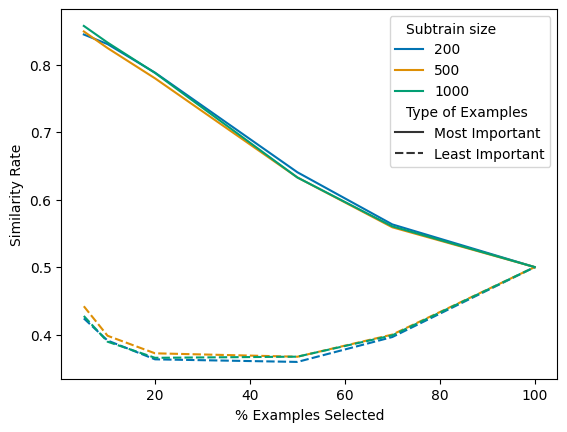

In [16]:
frac_list = [0.05, 0.1, 0.2, 0.5, 0.7, 1.0]

results_list = []

for subtrain_size in subtrain_sizes:
  attribution = results_dict[subtrain_size]

  idx_subtrain = torch.load(f'results/ecg5000/consistency_examples/results_idx_subtrain{subtrain_size}.pt')
  train_subset = Subset(train_dataset, idx_subtrain)
  subtrain_loader = DataLoader(train_subset)
  labels_subtrain = torch.cat([label for _, label in subtrain_loader])

  n_top_list = [int(frac * len(idx_subtrain)) for frac in frac_list]

  sim_most, sim_least = similarity_rates(
        attribution, labels_subtrain, labels_subtest, n_top_list
    )

  results_list += [
      [str(subtrain_size), "Most Important", 100 * frac, sim]
      for frac, sim in zip(frac_list, sim_most)
  ]
  results_list += [
      [str(subtrain_size), "Least Important", 100 * frac, sim]
      for frac, sim in zip(frac_list, sim_least)
  ]

results_df = pd.DataFrame(
    results_list,
    columns=[
        "Subtrain size",
        "Type of Examples",
        "% Examples Selected",
        "Similarity Rate",
    ],
)

sns.lineplot(
    data=results_df,
    x="% Examples Selected",
    y="Similarity Rate",
    hue="Subtrain size",
    style="Type of Examples",
    palette="colorblind",
)
plt.savefig(save_dir / "ecg5000_similarity_rates.pdf")

# Retraining model without opponents

In [17]:
for subtrain_size in subtrain_sizes:
  idx_opponents_subtrain = (results_dict[subtrain_size].mean(axis=0) < 0).nonzero().flatten()
  print(idx_opponents_subtrain)

  idx_subtrain = torch.load(f'results/ecg5000/consistency_examples/results_idx_subtrain{subtrain_size}.pt')
  idx_opponents_train = []
  for i in range(len(idx_opponents_subtrain)):
    idx_opponents_train.append(idx_subtrain[idx_opponents_subtrain[i]])

  torch.save(idx_opponents_train, save_dir / f"idx_opponents_train{subtrain_size}.pt")


tensor([ 11,  83, 134, 155, 162])
tensor([ 11,  83, 134, 155, 162, 223, 239, 245, 318, 326, 329, 383, 428, 461,
        471, 475])
tensor([ 11,  83, 134, 155, 162, 223, 239, 245, 318, 326, 329, 383, 428, 461,
        471, 475, 508, 549, 551, 563, 580, 629, 721, 729, 784, 787, 793, 795,
        830, 861, 896, 906, 909, 912, 926, 941, 965, 983, 989, 998])


In [18]:
for subtrain_size in subtrain_sizes:
  save_dir = Path.cwd() / f"results/ecg5000/consistency_examples"
  idx_opponents_train = torch.load(save_dir / f"idx_opponents_train{subtrain_size}.pt")

  idx_train = list(range(len(train_dataset)))
  idx_not_opponents = list(set(idx_train) - set(idx_opponents_train))

  print('Length train dataset original: ', len(train_dataset))

  train_dataset_proponents = Subset(train_dataset, idx_not_opponents)
  print('Length train dataset proponents: ',len(train_dataset_proponents))

  train_loader_proponents = DataLoader(train_dataset_proponents, batch_size, True)

  # Re-train the model only with proponents
  autoencoder = RecurrentAutoencoder(time_steps, n_features, dim_latent)
  save_dir = Path.cwd() / f"results/ecg5000/proponents_examples_{subtrain_size}"
  if not save_dir.exists():
      os.makedirs(save_dir)
  autoencoder.fit(
      device,
      train_loader_proponents,
      test_loader,
      save_dir,
      n_epochs,
      checkpoint_interval=checkpoint_interval,
  )


Length train dataset original:  4000
Length train dataset proponents:  3995


Length train dataset original:  4000
Length train dataset proponents:  3984


Length train dataset original:  4000
Length train dataset proponents:  3960


# Calculating final losses

In [19]:
autoencoder = RecurrentAutoencoder(time_steps, n_features, dim_latent)
save_dir = Path.cwd() / "results/ecg5000/consistency_examples"

autoencoder.load_state_dict(
    torch.load(save_dir / (autoencoder.name + ".pt")), strict=False
)

<All keys matched successfully>

In [20]:
autoencoder.to(device)

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 32, batch_first=True)
    (rnn2): LSTM(32, 16, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(16, 16, batch_first=True)
    (rnn2): LSTM(16, 32, batch_first=True)
    (output_layer): Linear(in_features=32, out_features=1, bias=True)
  )
  (loss_f): L1Loss()
)

In [21]:
print('Validation loss: ', autoencoder.test_epoch(device, subtest_loader))

Validation loss:  0.14900081


In [22]:
idx_test = list(range(len(test_dataset)))
idx_not_subtest = list(set(idx_test) - set(idx_subtest.tolist()))
test_not_subset = Subset(test_dataset, idx_not_subtest)
test_not_subset_loader = DataLoader(test_not_subset)
print(len(test_not_subset))

800


In [23]:
print('Test loss: ', autoencoder.test_epoch(device, test_not_subset_loader))

Test loss:  0.15967612


In [24]:
for subtrain_size in subtrain_sizes:
  autoencoder = RecurrentAutoencoder(time_steps, n_features, dim_latent)
  save_dir = Path.cwd() / f"results/ecg5000/proponents_examples_{subtrain_size}"

  autoencoder.load_state_dict(
      torch.load(save_dir / (autoencoder.name + ".pt")), strict=False
  )

  autoencoder.to(device)

  print('Subtrain size: ', subtrain_size)
  print('Validation loss: ', autoencoder.test_epoch(device, subtest_loader))
  print('Test loss: ', autoencoder.test_epoch(device, test_not_subset_loader))

Subtrain size:  200
Validation loss:  0.17305999
Test loss:  0.18517976
Subtrain size:  500
Validation loss:  0.17532024
Test loss:  0.19186127
Subtrain size:  1000
Validation loss:  0.15704472
Test loss:  0.16616826


# Anomaly detection

In [25]:
save_dir = Path.cwd() / "results/ecg5000/consistency_examples"
idx_opponents_train_200 = torch.load(save_dir / f"idx_opponents_train200.pt")
len(idx_opponents_train_200)

5

Text(0.5, 1.0, 'Random examples')

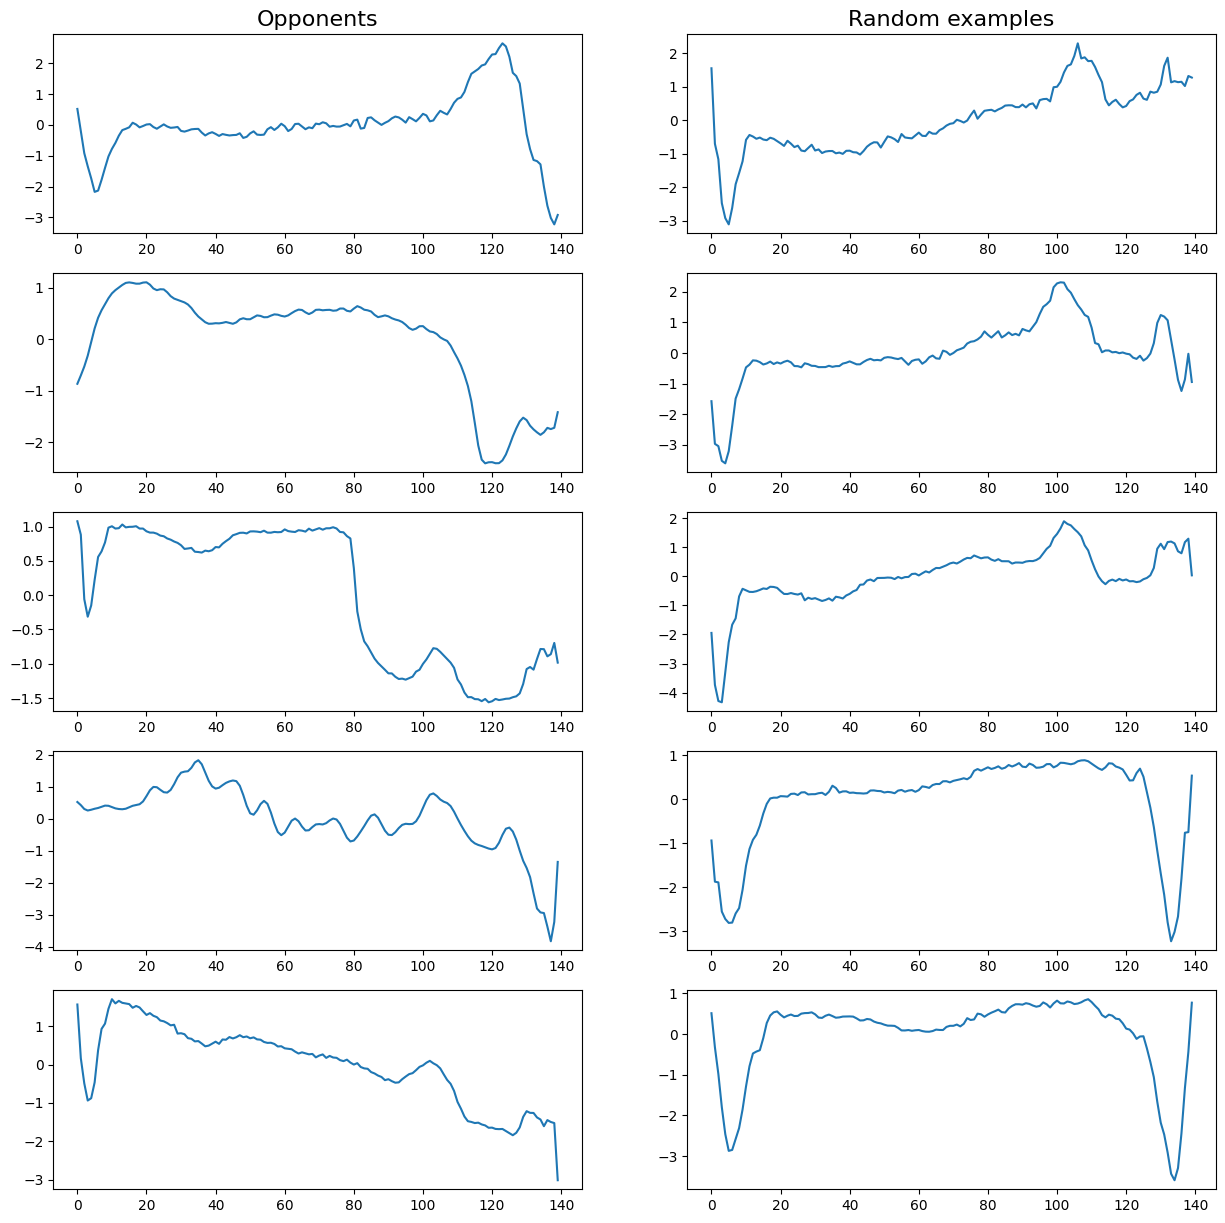

In [28]:
import random

fig, axes = plt.subplots(5, 2, figsize=(15, 15))

random_indices = random.sample(range(len(train_dataset)), 5)

for i in range(5):
  # plot oponents
  axes[i, 0].plot(train_dataset[idx_opponents_train_200[i]][0].numpy())
  # plot random
  axes[i, 1].plot(train_dataset[random_indices[i]][0].numpy())

axes[0][0].set_title('Opponents', fontsize=16)
axes[0][1].set_title('Random examples', fontsize=16)

In [31]:
save_dir = Path.cwd() / "results/ecg5000/consistency_examples"
idx_opponents_train_500 = torch.load(save_dir / f"idx_opponents_train500.pt")
len(idx_opponents_train_500)

16

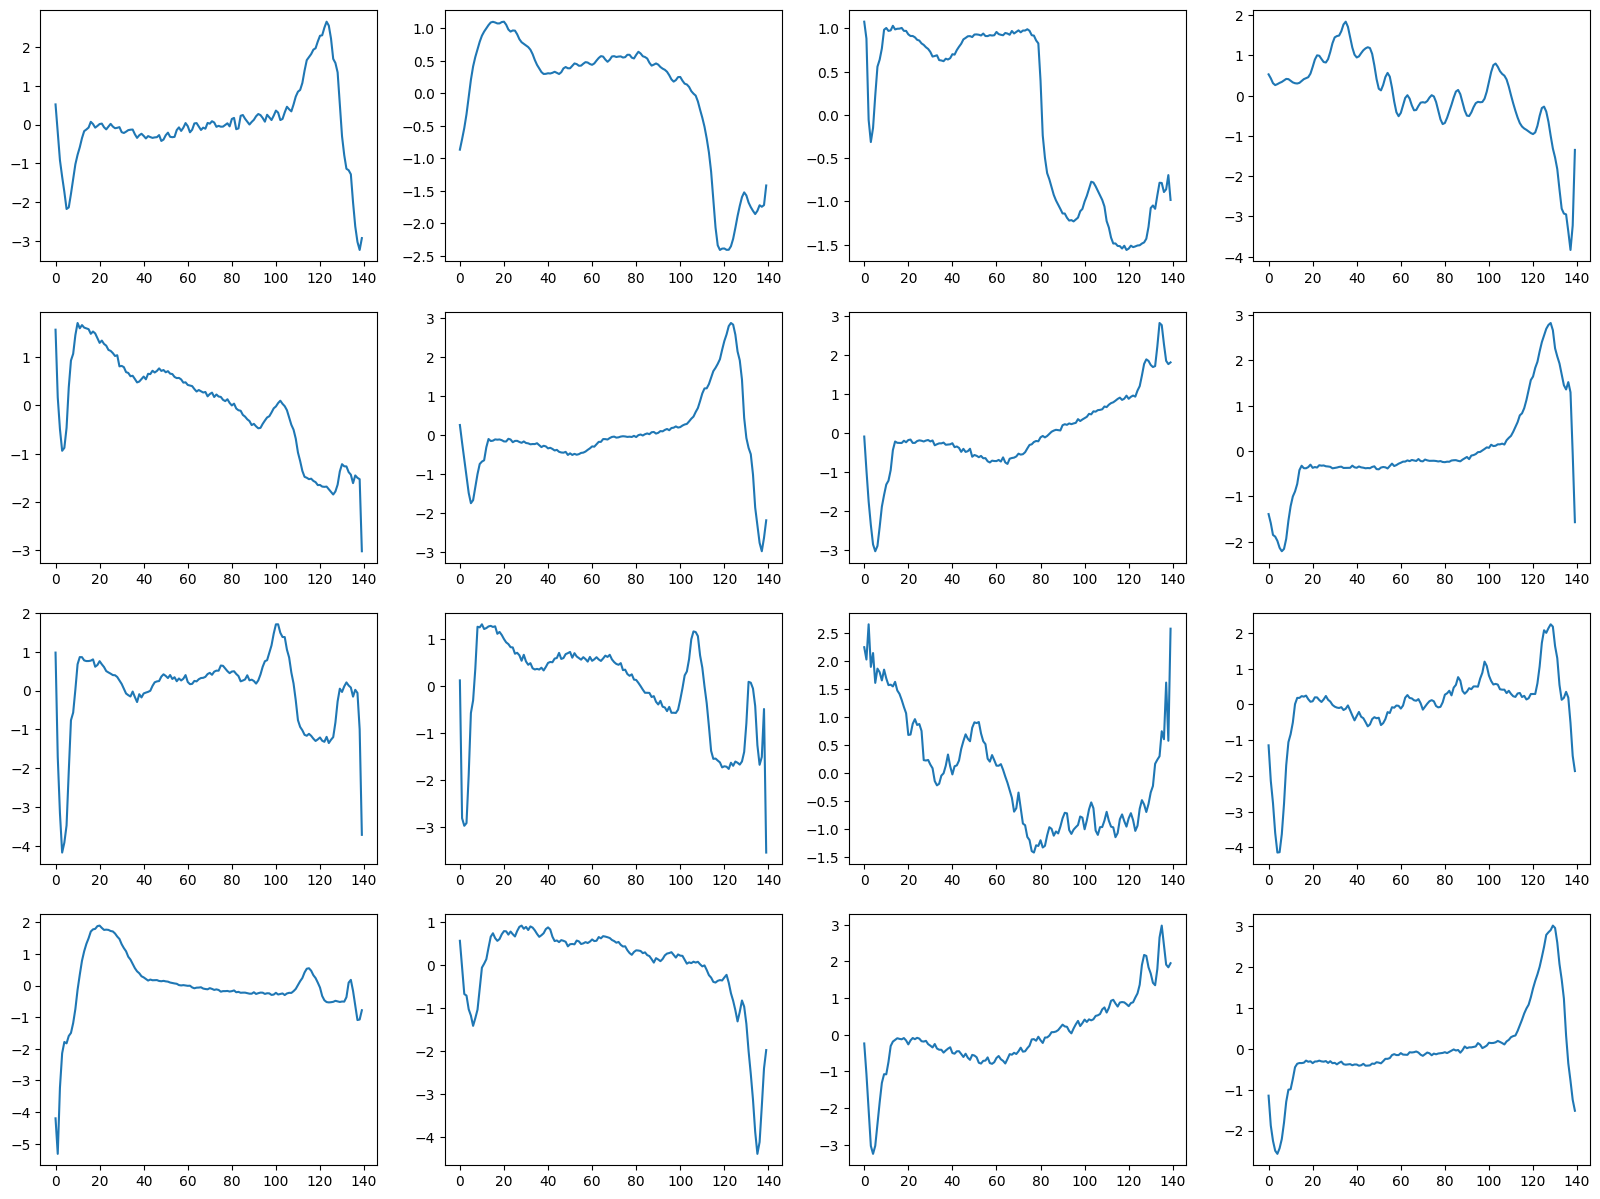

In [33]:
fig, axes = plt.subplots(4, 4, figsize=(20, 15))

for i in range(16):
  # Calculate the row and column indices using modulo
  row_idx = i // 4
  col_idx = i % 4

  # Plot opponents
  axes[row_idx, col_idx].plot(train_dataset[idx_opponents_train_500[i]][0].numpy())

In [34]:
save_dir = Path.cwd() / "results/ecg5000/consistency_examples"
idx_opponents_train_1000 = torch.load(save_dir / f"idx_opponents_train1000.pt")
len(idx_opponents_train_1000)

40

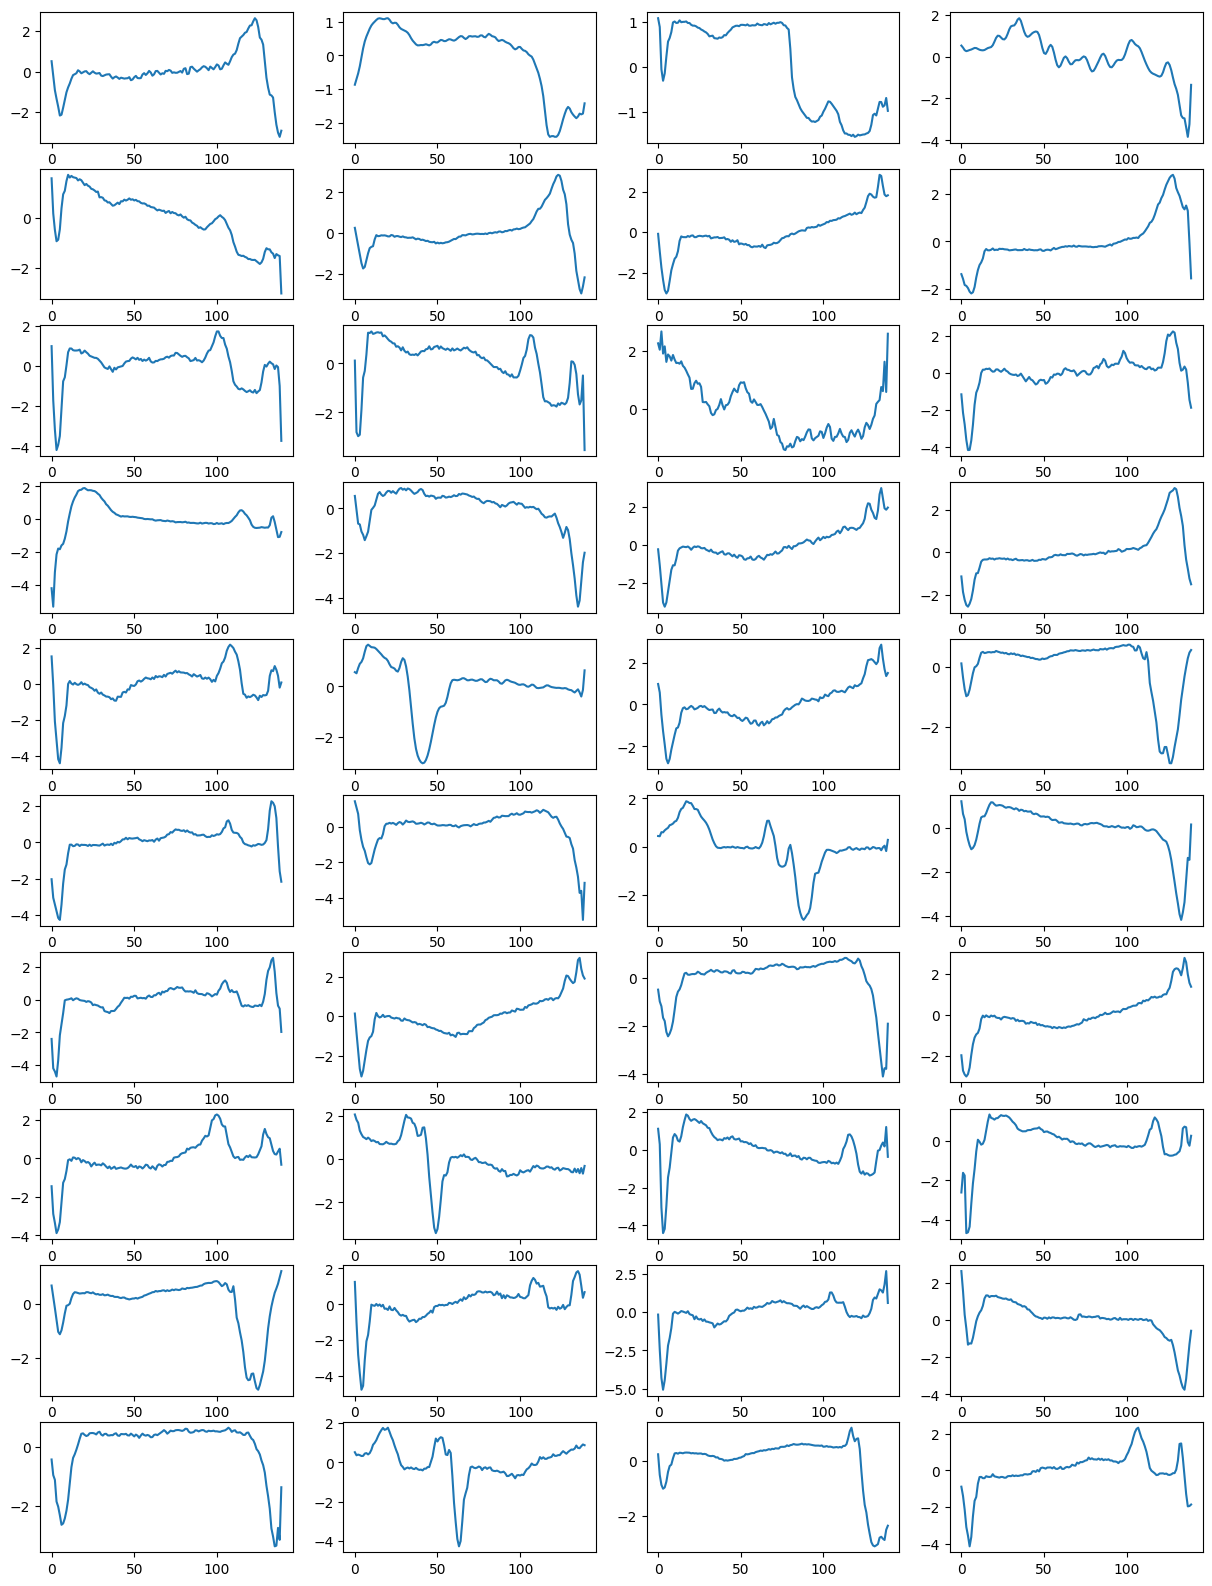

In [37]:
fig, axes = plt.subplots(10, 4, figsize=(15, 20))

for i in range(40):
    # Calculate the row and column indices using modulo
    row_idx = i // 4
    col_idx = i % 4

    # Plot opponents
    axes[row_idx, col_idx].plot(train_dataset[idx_opponents_train_1000[i]][0].numpy())